# whale back challenge, data wrangling, tensorflow models

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from skimage import io, transform
import skimage
import glob
from tqdm import tnrange, tqdm
from collections import Counter

%matplotlib inline

In [3]:
# some prep steps
data_folder = os.getcwd() + "/data/"
labels = pd.read_csv(data_folder+"train.csv")
train_folder = data_folder + "train/"
gray_train_folder = data_folder + "train_100x100_gray/"
test_folder = data_folder + "test/"
gray_test_folder = data_folder + "test_100x100_gray/"
images_glob_pattern = os.path.join(train_folder, '*.jpg')
glob_list = glob.glob(images_glob_pattern)
gray_glob_pattern = os.path.join(gray_train_folder, '*.jpg')
gray_glob_list = glob.glob(gray_glob_pattern)

In [4]:
glob_list

['/home/beno/Documents/python/whaleback_challenge/data/train/1b9802231.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/cd598b557.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/3823ee66f.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/df5f58347.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/d0524533d.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/f3bcd2538.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/fba371cc2.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/be0348b21.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/b4a486fbc.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/a78c4edad.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/d78e0ca84.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/18e740a2f.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train/d63ea9a2c.jpg',

In [5]:
round(np.random.rand()*len(glob_list))

16351

image before preprocessing:
shape:  (317, 1050, 3)


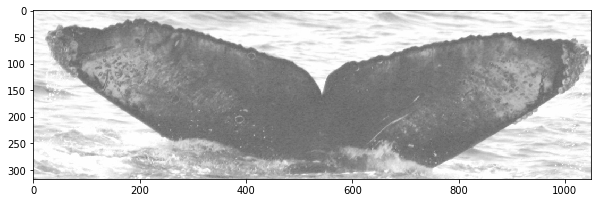

image after preprocessing: 
shape:  (100, 100)


/home/beno/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


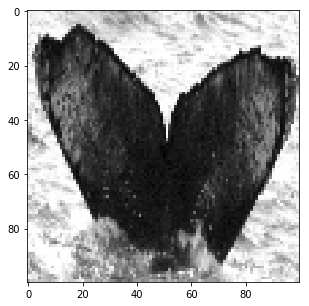

In [6]:
random_index = round(np.random.rand()*len(glob_list))
test_image = io.imread(glob_list[random_index])
print("image before preprocessing:")
print("shape: ",test_image.shape)
plt.figure(figsize=(10,5))
plt.imshow(test_image)
plt.show()
gray_image = io.imread(glob_list[random_index], as_gray=True)
gray_image = transform.resize(gray_image, (100,100), mode="reflect").astype(np.float)
print("image after preprocessing: ")
print("shape: ", gray_image.shape)
plt.figure(figsize=(10,5))
plt.imshow(gray_image, cmap="gray")
plt.show()

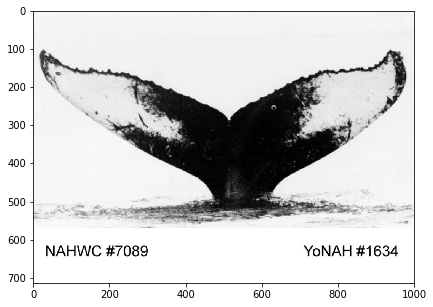

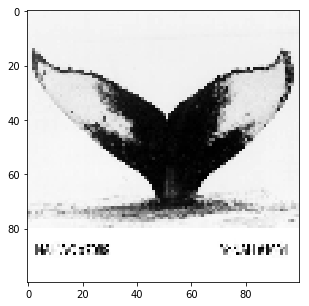

[[0.96078431 0.96470588 0.96470588 ... 0.96470588 0.96470588 0.96078431]
 [0.96078431 0.96078431 0.96470588 ... 0.96470588 0.96470588 0.96078431]
 [0.96078431 0.96078431 0.96078431 ... 0.96470588 0.96470588 0.96078431]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [7]:
test_image = io.imread("/home/beno/Documents/python/whaleback_challenge/data/train/3823ee66f.jpg", as_gray=True)
plt.figure(figsize=(10,5))
plt.imshow(test_image, cmap="gray")
plt.show()
test_image = transform.resize(test_image, (100,100), mode="reflect").astype(np.float) 
plt.figure(figsize=(10,5))
plt.imshow(test_image, cmap="gray")
plt.show()
print(test_image)

In [8]:
#print all pictures for one whale for first impression.
test_set = labels[labels["Id"]=="w_bfe77d0"]
#for image_id in test_set["Image"]:
#    cur_image = io.imread("data/train_100x100_gray/" + image_id)
#    plt.figure(figsize=(10,5))
#    plt.imshow(cur_image)
#    plt.show()


In [9]:
# load every picture as grayscale image, reshape then save to other folder
#for image in tqdm(glob_list):
#    gray_image = io.imread(image, as_gray=True)
#    gray_image = transform.resize(gray_image, (100,100), mode="reflect").astype(np.float)
#    io.imsave(gray_train_folder + image[-13:], gray_image)

In [10]:
tensor = tf.constant(test_image)
tensor

<tf.Tensor 'Const:0' shape=(100, 100) dtype=float64>

In [11]:
gray_glob_list

['/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/1b9802231.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/cd598b557.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/3823ee66f.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/df5f58347.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/d0524533d.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/f3bcd2538.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/fba371cc2.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/be0348b21.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/b4a486fbc.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/a78c4edad.jpg',
 '/home/beno/Documents/python/whaleback_challenge/data/train_100x100_gray/d78e0ca84.jpg',
 '/home/be

In [12]:
labels[labels["Image"]=="6fdd997e9.jpg"]["Id"].values[0]

'new_whale'

In [13]:
# save pictures in tensor
tensor_list = []
idx = 0
for image in tqdm(gray_glob_list):
    cur_image = io.imread(image, as_gray=True)
    image_id = image[-13:]
    whale_id = labels[labels["Image"]==image_id]["Id"].values[0]
    tensor_list.append([whale_id, cur_image])
#    if idx % 100:
        #labels_tensor = tf.concat([labels_tensor, t2], 0)
        #features_tensor = tf.constant(features)
#        print(labels)
#        print(features)
    #idx+=1
        
tensor_list = list(map(list, zip(*tensor_list)))
labels = np.array(tensor_list[0])
features = np.array(tensor_list[1])

100%|██████████| 25361/25361 [00:45<00:00, 557.62it/s]


In [16]:
tf_labels = tf.constant(labels)[:2000]
tf_features = tf.constant(features)[:2000]

In [17]:
dataset = tf.data.Dataset.from_tensor_slices({"feature": tf_features, "label": tf_labels})

In [105]:
tf_features

<tf.Tensor 'Const_1:0' shape=(25361, 100, 100) dtype=uint8>

In [95]:
dataset.output_types

{'features': tf.uint8, 'labels': tf.string}

In [20]:
batch_size = 512
dataset.shuffle(2000)
batches = dataset.batch(batch_size)

In [117]:
batches

<BatchDataset shapes: {feature: (?, 100, 100), label: (?,)}, types: {feature: tf.uint8, label: tf.string}>

In [21]:


sess = tf.Session()
iterator = batches.make_one_shot_iterator()
next_element = iterator.get_next()
no_of_batches = int(np.floor(labels.shape[0] / batch_size))
for i in tqdm(range(no_of_batches)):
    value = sess.run(next_element)
    print(value["feature"].shape)

sess.close()

  2%|▏         | 1/49 [00:02<01:39,  2.07s/it]

(512, 100, 100)
(512, 100, 100)
(512, 100, 100)
(464, 100, 100)


OutOfRangeError: End of sequence
	 [[node IteratorGetNext (defined at <ipython-input-21-aef931ec89ab>:5)  = IteratorGetNext[output_shapes=[[?,100,100], [?]], output_types=[DT_UINT8, DT_STRING], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/beno/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-aef931ec89ab>", line 5, in <module>
    next_element = iterator.get_next()
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 421, in get_next
    name=name)), self._output_types,
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 2069, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext (defined at <ipython-input-21-aef931ec89ab>:5)  = IteratorGetNext[output_shapes=[[?,100,100], [?]], output_types=[DT_UINT8, DT_STRING], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]


In [22]:
sess.close()

In [ ]:
def batch_data(num_data, batch_size):   
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs

In [29]:
counter = Counter(labels["Id"])
counter.most_common()

[('new_whale', 9664),
 ('w_23a388d', 73),
 ('w_9b5109b', 65),
 ('w_9c506f6', 62),
 ('w_0369a5c', 61),
 ('w_700ebb4', 57),
 ('w_3de579a', 54),
 ('w_564a34b', 51),
 ('w_fd3e556', 50),
 ('w_88e4537', 49),
 ('w_2b069ba', 48),
 ('w_d405854', 47),
 ('w_f0fe284', 45),
 ('w_789c969', 45),
 ('w_778e474', 40),
 ('w_5e8e218', 40),
 ('w_343f088', 40),
 ('w_a9304b9', 37),
 ('w_60ce6fc', 37),
 ('w_5a2634c', 37),
 ('w_6822dbc', 36),
 ('w_af367c3', 35),
 ('w_1ca9ab1', 34),
 ('w_f765256', 34),
 ('w_17b0d3a', 33),
 ('w_d72771c', 32),
 ('w_08630fd', 31),
 ('w_6cda039', 31),
 ('w_8c25681', 31),
 ('w_04003e9', 30),
 ('w_fd6a3ad', 30),
 ('w_51fc1fc', 30),
 ('w_2365d55', 29),
 ('w_59052ad', 29),
 ('w_6caff0f', 27),
 ('w_91cc02c', 25),
 ('w_bfcad53', 25),
 ('w_0a155b9', 24),
 ('w_b9e5911', 24),
 ('w_27597ff', 24),
 ('w_990921b', 24),
 ('w_cd4cb49', 24),
 ('w_75f6ffa', 24),
 ('w_0bc078c', 24),
 ('w_0135f5f', 23),
 ('w_5773c71', 23),
 ('w_e1ffbe2', 23),
 ('w_242fb46', 23),
 ('w_488865e', 22),
 ('w_8da30ad', 22)

https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right
create flipped images of underrepresented classes

In [10]:
loader = np.load("homework_09_data.npz")
train_data = loader['train_data']
train_labels = loader['train_labels']

val_data = loader['val_data']
val_labels = loader['val_labels']

test_data = loader['test_data']

In [11]:
# Normalize (between [0,1])? or standardize(mean=0, std=1)? for cnn data
def standardize(train, test):
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:]) / np.std(train, axis=0)[None,:]
    X_test = (test - np.mean(test, axis=0)[None,:]) / np.std(test, axis=0)[None,:]

    return X_train, X_test

In [12]:
train_data, val_data = standardize(train_data, val_data)

In [13]:
print(test_data.shape)
print(val_data.shape)

(1607, 120)
(1606, 120)


The skeleton of the class ```FeedForwardNet``` is provided in the following. This class implements a feed-forward neural network in Tensorflow. 
**Your task** is to complete the parts where it says ```### YOUR CODE HERE ###```. 

To complete the code properly, make sure that you make the computation graph based on the placeholders ```self.X``` and ```self.Y```. These two placeholders are created in the `build` function; you don't need to create them. You only need to use them.
* ```self.X```: a placeholder of shape ```[None,D]``` where the none dimension will be replaced by the number of instances, and $D$ is number of features.
* ```self.Y```: a placeholder of shape ```[None,K]``` where the none dimension will be replaced by the number of instances, and $K$ is number of classes.



In [51]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs
    

class FeedForwardNet:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, hidden_sizes, layer_types, name, learning_rate=0.001, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.hidden_sizes = hidden_sizes
        self.layer_types = layer_types
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
    
    def build(self, data_dim, num_classes):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, data_dim], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        
            hidden = self.X

            for ix, hidden_size in enumerate(self.hidden_sizes):
                W = tf.get_variable(f"{self.name}W{ix}", shape=[hidden.shape[1],hidden_size])
                b = tf.get_variable(f"{self.name}b{ix}", shape=[hidden_size])
                
                hidden = tf.nn.relu(hidden @ W + b)
                hidden = tf.nn.dropout(hidden, 1-self.dropout)
                
                self.weights.append(W)
                self.biases.append(b)
                    
            W_out = tf.get_variable(f"{self.name}W_out", shape=[hidden.shape[1],6])
            b_out = tf.get_variable(f"{self.name}b_out", shape=[6])
            
            self.weights.append(W_out)
            self.biases.append(b_out)
            
            self.logits = hidden @ W_out + b_out
            self.l2_norm = tf.add_n([tf.norm(w) for w in self.weights])
            self.cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits,labels=self.Y,name="cross_entropy_loss"))
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.logits > 0, tf.cast(self.Y, tf.bool)),tf.float32), name="accuracy")
            
            self.loss = self.cross_entropy_loss + self.l2_reg * self.l2_norm
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.opt_op = self.optimizer.minimize(self.loss, var_list=[*self.weights, *self.biases])
            
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        self.session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        session = self.session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            stopping_counter = 0
            
            for epoch in range(epochs):
                #if (epoch + 1) % 10 == 0:
                    #print(f"Epoch {epoch+1}/{epochs}")
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run([self.opt_op, self.loss], feed_dict={self.X: train_data[batch_ixs], self.Y: train_labels[batch_ixs]})
                    
                tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)
                if epoch > 20:
                    if val_losses[-1] > np.mean(val_losses[-20:]):
                        stopping_counter += 1
                if stopping_counter > 4:
                    print(f"ending training due to stopping criterion after epoch {epoch}")
                    break

    
        self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs), "epochs_trained": epoch}

In [54]:
#parameter testing loop:

#layer_types are not used in model. could/should be integrated soon.
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
hidden_sizes_list = [[128, 64, 32, 16], [32, 16], [64], [16, 32, 16]]
epochs = 250
batch_size_list = [512,256,128]
l2_reg_list = [0]
learning_rate_list = [0.001, 0.002, 0.005]
dropout_list = [0.2, 0.35, 0.5]

model_hist = []
train_acc_hist = []
val_acc_hist = []
hidden_sizes_hist = []
epochs_hist = []
batch_size_hist = []
l2_reg_hist = []
learning_rate_hist = []
dropout_hist = []
epochs_trained_hist = []

trained_models_count = 0
models_to_train = len(hidden_sizes_list) * len(l2_reg_list) * len(learning_rate_list) * len(dropout_list)* len(batch_size_list)

for hidden_sizes in hidden_sizes_list:
    for l2_reg in l2_reg_list:
        for learning_rate in learning_rate_list:
            for dropout in dropout_list:
                for batch_size in batch_size_list:
                    model_name = "model_%s_%s_%s_%s" % ('.'.join(str(p) for p in hidden_sizes), str(l2_reg), str(learning_rate), str(dropout))
                    current_model = FeedForwardNet(hidden_sizes, layer_types, model_name, learning_rate=learning_rate, l2_reg=l2_reg)
                    current_model.build(train_data.shape[1], num_classes=train_labels.shape[1])
                    current_model.train(train_data, train_labels, val_data, val_labels, epochs, batch_size=batch_size, dropout=dropout)

                    trained_models_count+=1
                    print(f"trainings finished: {trained_models_count}/{models_to_train}")
                    train_acc = current_model.hist['train_accuracy'][-1]
                    val_acc = current_model.hist['val_accuracy'][-1]
                    print(f"Training accuracy model {trained_models_count} (name: {model_name}): {train_acc:.4f}")
                    print(f"Validation accuracy model {trained_models_count} (name: {model_name}): {val_acc:.4f}")
                    print()
                    hidden_sizes_hist.append(str(hidden_sizes))
                    epochs_hist.append(epochs)
                    batch_size_hist.append(batch_size)
                    l2_reg_hist.append(l2_reg)
                    learning_rate_hist.append(learning_rate)
                    dropout_hist.append(dropout)
                    val_acc_hist.append(val_acc)
                    train_acc_hist.append(train_acc)
                    model_hist.append(model_name)
                    epochs_trained_hist.append(current_model.hist["epochs_trained"])


result_df = pd.DataFrame({"model": model_hist, "training_acc": train_acc_hist, "validation_acc": val_acc_hist,
                         "hidden_sizes": hidden_sizes_hist, "epochs":epochs_hist, "batch_size":batch_size_hist,
                         "l2_reg": l2_reg_hist, "learning_rate": learning_rate_hist, "dropout": dropout_hist, 
                          "epochs_trained": epochs_trained_hist})


ending training due to stopping criterion after epoch 57
trainings finished: 1/108
Training accuracy model 1 (name: model_128.64.32.16_0_0.001_0.2): 0.9947
Validation accuracy model 1 (name: model_128.64.32.16_0_0.001_0.2): 0.9799

ending training due to stopping criterion after epoch 45
trainings finished: 2/108
Training accuracy model 2 (name: model_128.64.32.16_0_0.001_0.2): 0.9965
Validation accuracy model 2 (name: model_128.64.32.16_0_0.001_0.2): 0.9815

ending training due to stopping criterion after epoch 33
trainings finished: 3/108
Training accuracy model 3 (name: model_128.64.32.16_0_0.001_0.2): 0.9976
Validation accuracy model 3 (name: model_128.64.32.16_0_0.001_0.2): 0.9813

ending training due to stopping criterion after epoch 58
trainings finished: 4/108
Training accuracy model 4 (name: model_128.64.32.16_0_0.001_0.35): 0.9952
Validation accuracy model 4 (name: model_128.64.32.16_0_0.001_0.35): 0.9795

ending training due to stopping criterion after epoch 39
trainings fin

ending training due to stopping criterion after epoch 83
trainings finished: 37/108
Training accuracy model 37 (name: model_32.16_0_0.002_0.2): 0.9867
Validation accuracy model 37 (name: model_32.16_0_0.002_0.2): 0.9681

ending training due to stopping criterion after epoch 57
trainings finished: 38/108
Training accuracy model 38 (name: model_32.16_0_0.002_0.2): 0.9882
Validation accuracy model 38 (name: model_32.16_0_0.002_0.2): 0.9721

ending training due to stopping criterion after epoch 47
trainings finished: 39/108
Training accuracy model 39 (name: model_32.16_0_0.002_0.2): 0.9877
Validation accuracy model 39 (name: model_32.16_0_0.002_0.2): 0.9720

ending training due to stopping criterion after epoch 91
trainings finished: 40/108
Training accuracy model 40 (name: model_32.16_0_0.002_0.35): 0.9837
Validation accuracy model 40 (name: model_32.16_0_0.002_0.35): 0.9647

ending training due to stopping criterion after epoch 62
trainings finished: 41/108
Training accuracy model 41 (na

ending training due to stopping criterion after epoch 31
trainings finished: 75/108
Training accuracy model 75 (name: model_64_0_0.005_0.2): 0.9927
Validation accuracy model 75 (name: model_64_0_0.005_0.2): 0.9761

ending training due to stopping criterion after epoch 54
trainings finished: 76/108
Training accuracy model 76 (name: model_64_0_0.005_0.35): 0.9878
Validation accuracy model 76 (name: model_64_0_0.005_0.35): 0.9695

ending training due to stopping criterion after epoch 39
trainings finished: 77/108
Training accuracy model 77 (name: model_64_0_0.005_0.35): 0.9909
Validation accuracy model 77 (name: model_64_0_0.005_0.35): 0.9744

ending training due to stopping criterion after epoch 35
trainings finished: 78/108
Training accuracy model 78 (name: model_64_0_0.005_0.35): 0.9916
Validation accuracy model 78 (name: model_64_0_0.005_0.35): 0.9724

ending training due to stopping criterion after epoch 59
trainings finished: 79/108
Training accuracy model 79 (name: model_64_0_0.005

In [59]:
result_df.to_csv("session2.csv", sep=";")

In [29]:
type(','.join(str(p) for p in hidden_sizes))

str

In [5]:
#You can change layer types and the number of neurons by changing the following variables.
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
hidden_sizes = [64, 32, 16]
epochs = 250
batch_size = 512


model1 = FeedForwardNet(hidden_sizes, layer_types, "no_regularization")
model1.build(train_data.shape[1], num_classes=train_labels.shape[1])

model1.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 25/250
Epoch 50/250
Epoch 75/250
Epoch 100/250
Epoch 125/250
Epoch 150/250
Epoch 175/250
Epoch 200/250
Epoch 225/250
Epoch 250/250


In [47]:
#You can change layer types and the number of neurons by changing the following variables.
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
hidden_sizes = [128, 64, 32, 16]
epochs = 250
batch_size = 256


model2 = FeedForwardNet(hidden_sizes, layer_types, "test_nn", learning_rate=0.001)
model2.build(train_data.shape[1], num_classes=train_labels.shape[1])

model2.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size, dropout=0.2)

Epoch 10/250
Epoch 20/250
Epoch 30/250
Epoch 40/250
ending training due to stopping criterion


#### Plot the training and validation losses over the epochs. What do you notice?

model 2


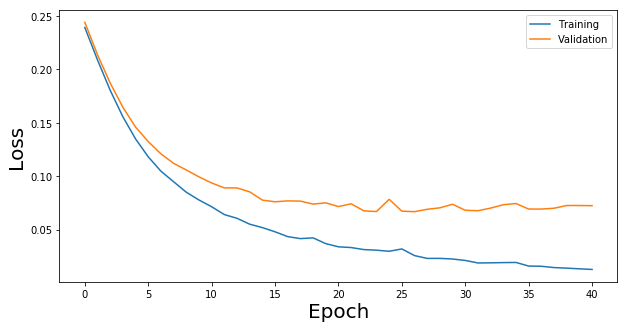

In [45]:
"""
print("model 1")
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training")
plt.plot(model1.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))
plt.plot(model2.hist['train_loss'][5::], label="Training")
plt.plot(model2.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

In [30]:
val_loss = model2.hist["val_loss"]

In [38]:
[val_loss[-k] > np.mean(val_loss[-k-20:-k]) for k in range(len(val_loss),21,-1)].index(True)

41

In [33]:
test = np.array(range(20))
np.mean(test[-5-5:-5])

12.0

#### Now plot the training and validation accuracies over the epochs.

model 1


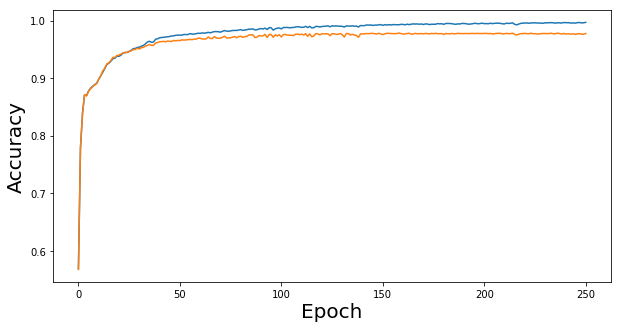

model 2


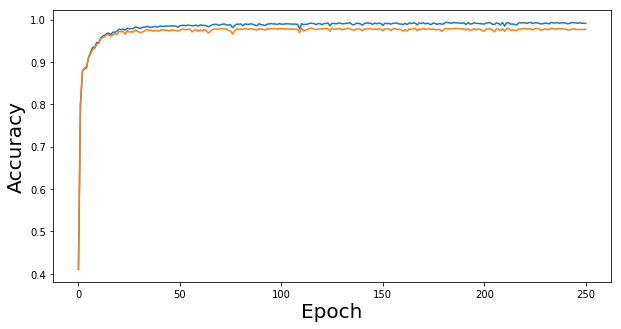

In [8]:
print("model 1")
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'])
plt.plot(model1.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()

print("model 2")
plt.figure(figsize=(10,5))

plt.plot(model2.hist['train_accuracy'])
plt.plot(model2.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()

In [9]:
train_acc_1 = model1.hist['train_accuracy'][-1]
val_acc_1 = model1.hist['val_accuracy'][-1]

train_acc_2 = model2.hist['train_accuracy'][-1]
val_acc_2 = model2.hist['val_accuracy'][-1]

print(f"Training accuracy model 1: {train_acc_1:.3f}")
print(f"Validation accuracy model 1: {val_acc_1:.3f}")
print()

print(f"Training accuracy model 2: {train_acc_2:.3f}")
print(f"Validation accuracy model 2: {val_acc_2:.3f}")
print()

Training accuracy model 1: 0.997
Validation accuracy model 1: 0.978

Training accuracy model 2: 0.991
Validation accuracy model 2: 0.977



### Plot the losses and accuracies of the models in one plot to compare them.

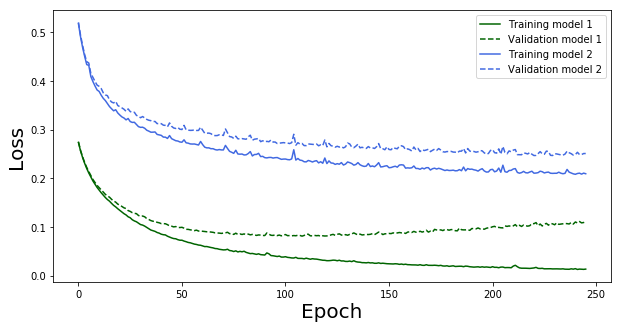

In [10]:
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_loss'][5::], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_loss'][5::], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_loss'][5::], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

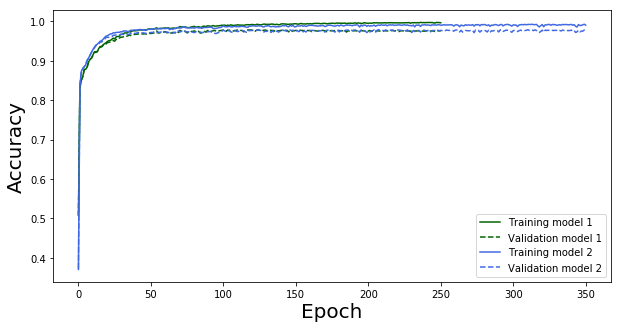

In [34]:
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_accuracy'], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_accuracy'], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_accuracy'], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

## Challenge

Notice that we also have the variable `test_data`. **Get creative** and build a model yourself!

Submit your predictions of the test data to Moodle to enter the leaderboard. We will announce the winning team after the Christmas break!

You can output the predictions of the test data using:

In [19]:
test_preds = NN_dropout_regularization.logits.eval({NN_dropout_regularization.X: test_data},
                                        session=NN_dropout_regularization.session).argmax(1)

We will only consider submission as plain text files with **exactly** the following formatting as our `sample_submission.txt`

In [20]:
string = ""
with open("sample_submission.txt", "r") as f:
    string = f.read()
print(string[:19])
print("...")

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.txt'

You can use the following command to save your predictions:

In [ ]:
np.savetxt("your_submission.txt", test_preds, fmt='%i')